# Figure 2: Spline generalized linear model (GLM) captures dLGN tuning properties.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import re
import ast
import json
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, randomized_svd
from statannotations.Annotator import Annotator
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from utils import *

In [3]:
color_dict = get_color_dict(color_names=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'lightblue'])

# Load data

In [4]:
filename = '../data/population_data.csv'
data_population = pd.read_csv(filename, converters={'filt_opto': preprocess_array_string, 'filt_run': preprocess_array_string, 'filt_eye': preprocess_array_string})
# csv formatting
data_population['filt_opto'] = data_population['filt_opto'].apply(str_to_array)
data_population['filt_run'] = data_population['filt_run'].apply(str_to_array)
data_population['filt_eye'] = data_population['filt_eye'].apply(str_to_array)

In [5]:
data_strf = pd.read_csv('../data/strfs_spline.csv').applymap(decode_array)

# Define example neurons

In [6]:
keys = [{'m': 'Ntsr1Cre_2019_0008', 's': 5, 'e': 8, 'u': 19},
        {'m': 'Ntsr1Cre_2019_0008', 's': 6, 'e': 6, 'u': 35},
        {'m': 'Ntsr1Cre_2019_0008', 's': 3, 'e': 7, 'u': 25},
       ]

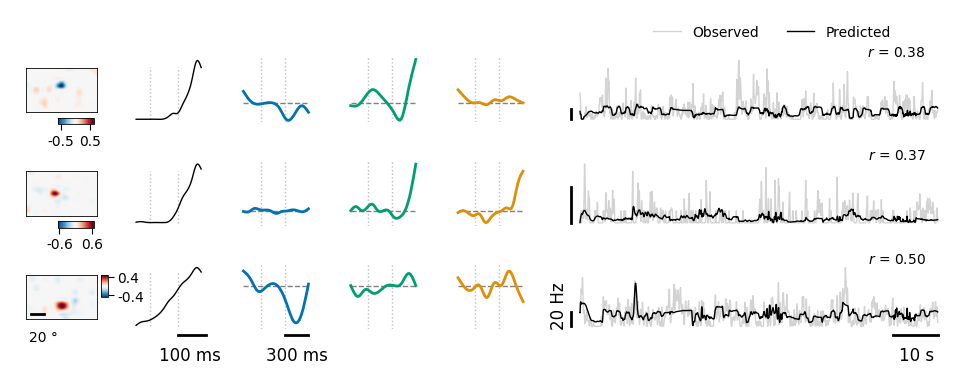

In [7]:
cmap = 'RdBu_r'
key = keys[0]

srf_panels = ['a', 'h', 'o']
trf_panels = ['b', 'i', 'p']
opto_panels = ['c', 'j', 'q']
run_panels = ['d', 'k', 'r']
eye_panels = ['e', 'l', 's']
pred_panels = ['f', 'm', 't']

# sRF
sRF_xlim = [0,20]

#tRF
data_fs = 60
ts = 1/data_fs
ylim_trf = [-.1, .6]

# predictions
pred_start_sec = -3
pred_stop_sec = 80
pred_y_bar = 20
pred_ylim = [-40,120]
pred_x_bar = 10

perm_xlim = [-.1,.6]
perm_ylim = [-.5, 3.5]

with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    abcdeffff
    hijklmmmm
    opqrstttt
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(6, 1.8),
        dpi=200,
    )

    txt_kwargs = dict(
        color="black", fontsize="larger"
    )
    
    for i, key in enumerate(keys):
        # Fetch data
        data = pd.read_csv('../data/{:s}_s{:02d}_e{:02d}_u{:02d}.csv'.format(key['m'], key['s'], key['e'], key['u'])).applymap(decode_array)
        strf = data.at[0,'strf']
        sRF = data.at[0,'srf']
        vmax_sRF = np.max([abs(np.min(sRF)), np.max(sRF)])
        dims_sRF = sRF.shape
        tRF = data.at[0,'trf']
        tRF_spl = data_strf[np.array((data_strf['m']==key['m']) & (data_strf['s']==key['s']) & (data_strf['e']==key['e']) & (data_strf['u']==key['u']))]['trf_spl'].values[0]
        opto_kernel = data.at[0,'filt_opto']
        run_kernel = data.at[0,'filt_run']
        eye_kernel = data.at[0,'filt_eye']
        kernel_ylim = [np.hstack([opto_kernel, run_kernel, eye_kernel]).min()-.1, np.hstack([opto_kernel, run_kernel, eye_kernel]).max()+.1]
        # Predictions
        y_test = data.at[0,'y_test']
        yhat_test = data.at[0,'yhat_test']
        pred_tv = np.linspace(0, y_test.shape[0] / data_fs, y_test.shape[0])
        pred_trange = [np.where(pred_tv>pred_start_sec)[0][0], np.where(pred_tv>pred_stop_sec)[0][0]]
        obs = y_test[pred_trange[0]:pred_trange[1]]
        pred = yhat_test[pred_trange[0]:pred_trange[1]]
        tv = pred_tv[pred_trange[0]:pred_trange[1]]
        
        # sRF
        ax = ax_dict[srf_panels[i]]    
        im = ax.imshow(sRF, cmap='RdBu_r', interpolation='spline16', vmin=-vmax_sRF, vmax=vmax_sRF, origin='lower')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        if srf_panels[i] in ['a', 'h']:
            axins = inset_axes(
                            ax,
                            width="50%", 
                            height="15%",  
                            loc="center",
                            bbox_to_anchor=(0.2, -0.7, 1, 1),
                            bbox_transform=ax.transAxes,
                            borderpad=0,
            )
            cbar = fig.colorbar(im, cax=axins, ticks=[-np.round(vmax_sRF-.1,1), np.round(vmax_sRF-.1,1)], orientation='horizontal')
            cbar.ax.tick_params(labelsize=5)
            cbar.set_ticklabels([-np.round(vmax_sRF-.1,1), np.round(vmax_sRF-.1,1)])
        if srf_panels[i]=='o':
            axins = inset_axes(
                            ax,
                            width="10%",  
                            height="50%",  
                            loc="center",
                            bbox_to_anchor=(0.6, 0.25, 1, 1),
                            bbox_transform=ax.transAxes,
                            borderpad=0,
            )
            cbar = fig.colorbar(im, cax=axins, ticks=[-np.round(vmax_sRF-.1,1), np.round(vmax_sRF-.1,1)], orientation='vertical')
            cbar.ax.tick_params(labelsize=5)
            cbar.set_ticklabels([-np.round(vmax_sRF-.1,1), np.round(vmax_sRF-.1,1)])

        # tRF
        ax = ax_dict[trf_panels[i]]
        x_axis_trf = np.arange(-tRF.shape[0]*ts, 0, ts)*1000 # ms
        x_axis_trf_spl = np.linspace(x_axis_trf[0], x_axis_trf[-1], tRF_spl.shape[0])
        ax.plot(x_axis_trf_spl, tRF_spl, 'k')
        for xtick in [-200, -100]:
            ax.vlines(x=xtick, ymin=0, ymax=tRF.max(), color='gray', linestyle=':', alpha=.5)
        #ax.set_ylim(ylim_trf)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

        # opto kernel
        ax = ax_dict[opto_panels[i]]
        x_axis_opto = (np.arange(-(opto_kernel.shape[0]*ts)-ts, 0-ts, ts)*1000).astype('int') # ms
        ax.plot(x_axis_opto, opto_kernel, color_dict['blue'], lw=1)
        ax.hlines(y=0, xmin=x_axis_opto[0], xmax=x_axis_opto[-1], color='gray', linestyle='--', lw=.5)
        for xtick in [-633, -333]:
            ax.vlines(x=xtick, ymin=kernel_ylim[0], ymax=kernel_ylim[1], color='gray', linestyle=':', alpha=.5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_ylim(kernel_ylim)
        
        # run kernel
        ax = ax_dict[run_panels[i]]
        x_axis_run = (np.arange(-(run_kernel.shape[0]*ts)-ts, 0-ts, ts)*1000).astype('int') # ms
        ax.plot(x_axis_run, run_kernel, color_dict['green'], lw=1)
        ax.hlines(y=0, xmin=x_axis_run[0], xmax=x_axis_run[-1], color='gray', linestyle='--', lw=.5)
        for xtick in [-633, -333]:
            ax.vlines(x=xtick, ymin=kernel_ylim[0], ymax=kernel_ylim[1], color='gray', linestyle=':', alpha=.5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_ylim(kernel_ylim)

        # eye kernel
        ax = ax_dict[eye_panels[i]]
        x_axis_eye = (np.arange(-(eye_kernel.shape[0]*ts)-ts, 0-ts, ts)*1000).astype('int') # ms
        ax.hlines(y=0, xmin=x_axis_eye[0], xmax=x_axis_eye[-1], color='gray', linestyle='--', lw=.5)
        ax.plot(x_axis_eye, eye_kernel, color_dict['orange'], lw=1)
        for xtick in [-633, -333]:
            ax.vlines(x=xtick, ymin=kernel_ylim[0], ymax=kernel_ylim[1], color='gray', linestyle=':', alpha=.5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_ylim(kernel_ylim)
        
        # predictions
        ax = ax_dict[pred_panels[i]]
        ax.plot(tv, obs, color='lightgray', label='Observed',lw=.5)
        ax.plot(tv, pred, color='black', label='Predicted', lw=.5)
        #ax.set_ylim(pred_ylim)
        # correlation coefficient
        ax.set_title('$r$ = {:.2f}'.format(data.at[0,'r_test']), fontsize=5, x=.85, y=.9)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
    # x axis
    # sRF
    num_px = 4
    ax_dict['o'].plot([1, num_px+1], [1, 1], 'k', lw=1)
    ax_dict['o'].set_xlabel(f'{sRF_xlim[1]} °', fontsize=5, x=0.25)
    # tRF
    ax_dict['p'].spines['bottom'].set_visible(True)
    ax_dict['p'].spines['bottom'].set_bounds([-100,0])
    ax_dict['p'].spines['bottom'].set_linewidth(1)
    ax_dict['p'].spines['bottom'].set_position(('outward', 2))
    ax_dict['p'].set_xlabel('100 ms', y=0, x=.8)
    # kernel
    ax_dict['q'].spines['bottom'].set_visible(True)    
    ax_dict['q'].spines['bottom'].set_bounds((x_axis_opto[-1]-300, x_axis_opto[-1]))
    ax_dict['q'].spines['bottom'].set_linewidth(1)
    ax_dict['q'].spines['bottom'].set_position(('outward', 2))
    ax_dict['q'].set_xlabel('300 ms', y=0, x=.8)
    # predictions
    ax_dict['t'].spines['bottom'].set_visible(True)
    ax_dict['t'].spines['bottom'].set_bounds([pred_stop_sec, pred_stop_sec-pred_x_bar])
    ax_dict['t'].spines['bottom'].set_linewidth(1)
    ax_dict['t'].spines['bottom'].set_position(('outward', 2))
    ax_dict['t'].set_xlabel(f'{pred_x_bar} s', y=0, x=.9)
    ax_dict['f'].legend(ncol=2, frameon=False, bbox_to_anchor=[.2,1.1])
    
    # y axis
    # predictions
    for label in ['f', 'm', 't']:
        ax_dict[label].spines['left'].set_visible(True)
        ax_dict[label].spines['left'].set_bounds([0, pred_y_bar])
        ax_dict[label].spines['left'].set_linewidth(1)
        ax_dict[label].spines['left'].set_position(('data', -2))
    
    ax_dict['t'].set_ylabel(f'{pred_y_bar} Hz', loc='bottom', labelpad=1)

    plt.subplots_adjust(wspace=0.5, hspace=0.6)

Permutation test:

Neuron 1:
	stimulus p-value = 5.72E-02
	opto p-value = 5.75E-07
	run p-value = 4.85E-01
	eye p-value = 5.21E-01
Neuron 2:
	stimulus p-value = 2.31E-03
	opto p-value = 1.00E+00
	run p-value = 1.06E-01
	eye p-value = 5.72E-03
Neuron 3:
	stimulus p-value = 2.31E-03
	opto p-value = 5.75E-07
	run p-value = 6.80E-01
	eye p-value = 8.76E-01


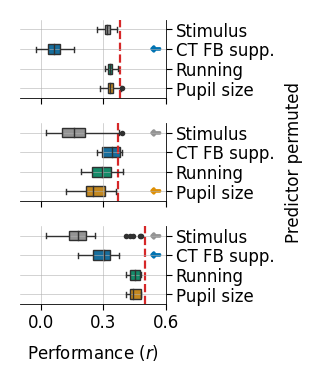

In [8]:
alpha = .05
perm_panels = ['a', 'b', 'c']
with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    a
    b
    c
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(1.5, 1.8),
        dpi=200,
    )

    txt_kwargs = dict(
        color="black", fontsize="larger"
    )
    
    for i, key in enumerate(keys):
        data = pd.read_csv('../data/{:s}_s{:02d}_e{:02d}_u{:02d}.csv'.format(key['m'], key['s'], key['e'], key['u'])).applymap(decode_array)
        
        # Get permutation scores
        scores_all = []
        label = []
        perm_kernel_idxs = []
        for k, kernel_type in enumerate(['stim', 'opto','run', 'eye']):
            scores = data.at[0,'perm_score_{:s}'.format(kernel_type)]
            scores_all.append(scores)
            for s in range(scores.shape[0]):
                label.append(kernel_type)
            perm_kernel_idxs.append(np.ones((scores.shape[0]))*k)
        scores_all = np.hstack(scores_all)
        perm_kernel_idxs = np.hstack(perm_kernel_idxs)
        perm_df = pd.DataFrame(dict(kernel=label,score=scores_all, idx=perm_kernel_idxs))
        
        # p-values 
        pvals = data_population[(data_population['m']==key['m']) & 
                                                   (data_population['s']==key['s']) & 
                                                   (data_population['e']==key['e']) & 
                                                   (data_population['u']==key['u'])][['perm_pvalue_stim', 'perm_pvalue_opto', 'perm_pvalue_run', 'perm_pvalue_eye']].values[0]
        idx_kernel_signif = np.where(pvals<alpha)[0]
        print(f'Neuron {i+1}:')
        print('\tstimulus p-value = {:.2E}'.format(pvals[0]))
        print('\topto p-value = {:.2E}'.format(pvals[1]))
        print('\trun p-value = {:.2E}'.format(pvals[2]))
        print('\teye p-value = {:.2E}'.format(pvals[3]))
        
        # Plotting
        ax = ax_dict[perm_panels[i]]
        palette = [color_dict['gray'], color_dict['blue'], color_dict['green'], color_dict['orange']]
        sns.boxplot(data=perm_df, 
                    x='score', 
                    y='idx', 
                    orient='h',
                ax=ax,
                palette=palette,
                fliersize=2,
                flierprops={"marker": "."},
                    width=0.5,
               )
        for idx_kernel in idx_kernel_signif:
            ax.scatter(0.55, idx_kernel, marker='$\leftarrow$', color=palette[idx_kernel], s=10)

        ax.axvline(x=data.at[0,'r_test'], color='tab:red', linestyle='--', lw=.8, zorder=1)
        ax.set_xticks(np.linspace(0,perm_xlim[-1], 3))
        ax.yaxis.tick_right()
        ax.set_yticks(np.linspace(0,3,4))
        ax.set_yticklabels(['Stimulus', 'CT FB supp.','Running', 'Pupil size'])
        ax.set_xlim(perm_xlim)
        ax.set_ylim(perm_ylim)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(True)
        if i<2:
            ax.set_xlabel('')
            ax.set_xticklabels([])
        else:
            ax.yaxis.set_label_position("right")
            ax.set_xlabel('Performance ($r$)')
        if i == 1:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel('Predictor permuted')
        else:
            ax.set_ylabel('')
        ax.invert_yaxis()
        ax.grid(lw=.2)

# Population analysis

In [9]:
# tRF
tRFs = np.vstack(data_strf['trf_spl'].values)
tRF_tv = np.vstack(data_strf['trf_spl_tv'].values)[0]
p_values_tRF = data_population['perm_pvalue_stim'].values
# Account for polarity to not show in temporal kernel
tRFs_flip = []
tRFs_flip_AUC = []
for i in range(tRFs.shape[0]):
    tRF = tRFs[i,:]
    # Account for rotation invariance of SVD
    if sum(tRF[50:])<0:
        tRF = tRF*(-1) 
    tRFs_flip.append(tRF)
    tRFs_flip_AUC.append(np.sum(tRF))
# Sort tRFs by AUC  
tRFs_flip = np.vstack(tRFs_flip)
idxs = np.array(tRFs_flip_AUC)
idxs_sorted_idxs = np.flip(np.array(idxs).argsort())
tRFs_sorted = tRFs_flip[idxs_sorted_idxs[::-1]]
p_values_tRF_sorted = np.expand_dims(p_values_tRF[idxs_sorted_idxs], axis=1)

# CT FB supp. (opto)
kernels_opto = np.vstack(data_population['filt_opto'].values)
p_values_opto = data_population['perm_pvalue_opto'].values
# Sort by area under the curve of the kernel
idxs = sum(kernels_opto.T)
idxs_sorted_idxs = np.array(idxs).argsort()
idxs_sorted_idxs = np.flip(idxs_sorted_idxs)
kernels_opto_sorted = kernels_opto[idxs_sorted_idxs[::-1]]
p_values_opto_sorted = np.expand_dims(p_values_opto[np.flip(idxs_sorted_idxs)], axis=1)

# Run
kernels_run = np.vstack(data_population['filt_run'].values)
p_values_run = data_population['perm_pvalue_run'].values
# Sort by area under the curve of the kernel
idxs = sum(kernels_run.T)
idxs_sorted_idxs = np.array(idxs).argsort()
kernels_run_sorted = kernels_run[idxs_sorted_idxs[::-1]]
p_values_run_sorted = np.expand_dims(p_values_run[np.flip(idxs_sorted_idxs)], axis=1)

# Eye
kernels_eye = np.vstack(data_population['filt_eye'].values)
p_values_eye = data_population['perm_pvalue_eye'].values
# Sort by area under the curve of the kernel
idxs = sum(kernels_eye.T)
idxs_sorted_idxs = np.array(idxs).argsort()
kernels_eye_sorted = kernels_eye[idxs_sorted_idxs[::-1]]
p_values_eye_sorted = np.expand_dims(p_values_eye[np.flip(idxs_sorted_idxs)], axis=1)

data_fs = 60
ts = 1/data_fs
kernels_tv = (np.arange(-(kernels_opto.shape[1]*ts), 0-ts/2, ts)*1000).astype('int') # ms

Significant tRF neurons: (85/122) 69%
Significant opto neurons: (12/122) 9%
Significant run neurons: (13/122) 10%
Significant eye neurons: (23/122) 18%


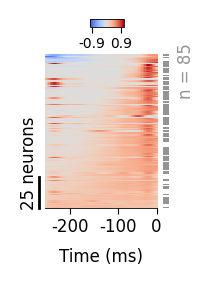

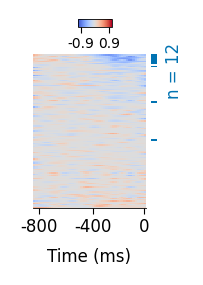

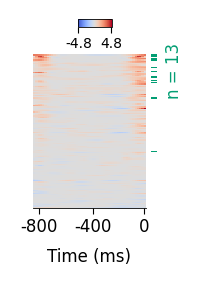

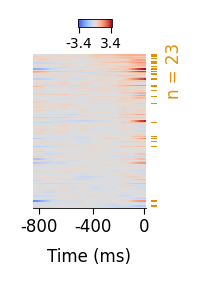

In [10]:
cmap='coolwarm'
signif_level = 0.05

# Loop over kernels
kernel_names = ['tRF', 'opto', 'run', 'eye']
kernels_sorted = [tRFs_sorted, kernels_opto_sorted, kernels_run_sorted, kernels_eye_sorted]
kernels_pval_sorted = [p_values_tRF_sorted, p_values_opto_sorted, p_values_run_sorted, p_values_eye_sorted]
kernel_tv = [tRF_tv, kernels_tv, kernels_tv, kernels_tv]
kernel_tv_label = [np.array([0, -100, -200]), np.array([0, -400, -800]), np.array([0, -400, -800]), np.array([0, -400, -800])]
colors = [color_dict['gray'], color_dict['blue'], color_dict['green'], color_dict['orange']]
    
for i in range(len(kernel_names)):
    with plt.style.context("matplotlib_config.txt"):
        mosaic = """
        ab
        """
        fig, ax_dict = plt.subplot_mosaic(
            mosaic,
            figsize=(.8,1.02),
            gridspec_kw={"width_ratios":[1, 0.05]},
        )

        txt_kwargs = dict(
            color="black", fontsize="larger"
        )
        axs=[ax_dict['a'], ax_dict['b']]

        # Plotting
        cmap_pvalues = LinearSegmentedColormap.from_list(colors[i], ['white', 'white'], N=10)
        cmap_pvalues.set_under(colors[i])
        kernel_vminmax = np.max([np.max(kernels_sorted[i]), abs(np.min(kernels_sorted[i]))])
        xticklabels = kernel_tv_label[i]
        xticks = []
        for xticklabel in xticklabels:
            closest_val_tv = abs(abs(kernel_tv[i])-np.abs(xticklabel)).argmin()
            xticks.append(closest_val_tv)
        # Heatmap
        ax = axs[0]
        im = ax.imshow(kernels_sorted[i], cmap=cmap, vmin=-kernel_vminmax, vmax=kernel_vminmax, aspect='auto', interpolation='None')
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        ax.set_yticks([])
        ax.set_xlabel('Time (ms)')
        # Colorbar
        axins = inset_axes(
                        ax,
                        width="30%",
                        height="5%", 
                        loc="center",
                        bbox_to_anchor=(0.05, .7, 1, 1),
                        bbox_transform=ax.transAxes,
                        borderpad=0,
        )
        cbar = fig.colorbar(im, cax=axins, ticks=[-np.round(kernel_vminmax,1)+.1, np.round(kernel_vminmax,1)-.1], orientation='horizontal')
        cbar.ax.tick_params(labelsize=5)
        cbar.set_ticklabels([-np.round(kernel_vminmax,1), np.round(kernel_vminmax,1)])

        sns.despine(left=True)

        # p-values
        ax = axs[1]
        num_signif_neur = np.where(kernels_pval_sorted[i]<0.05)[0].shape[0]
        print('Significant {:s} neurons: ({:d}/122) {:d}%'.format(kernel_names[i], num_signif_neur, int(num_signif_neur/122*100)))
        ax.imshow(kernels_pval_sorted[i], vmin=signif_level, cmap=cmap_pvalues, aspect='auto', interpolation='None')
        ax.axes.set_axis_off()
        fig.text(s='n = {:d}'.format(num_signif_neur), color=colors[i], x=.95, y=.68, rotation=90)
        
        # y axis
        if i==0:
            ax_dict['a'].spines['left'].set_visible(True)
            ax_dict['a'].spines['left'].set_bounds([kernels_sorted[i].shape[0]-1, kernels_sorted[i].shape[0]-25])
            ax_dict['a'].spines['left'].set_linewidth(1)
            ax_dict['a'].spines['left'].set_position(('outward', 2))
            fig.text(s=f'25 neurons', x=-.03, y=.14, rotation=90)
        else:
            ax_dict['a'].spines['left'].set_visible(False)

        fig.subplots_adjust(wspace=0.1)

# Stats on 'Pupil size' kernel vs. 'Running' kernel

* time from half max to peak

In [11]:
alpha = 0.05

data_fs = 60
ts = 1/data_fs
kernels_tv = (np.arange(-(kernels_opto.shape[1]*ts), 0-ts/2, ts)*1000).astype('int') # ms

kernels_run = np.vstack(data_population['filt_run'].values)
p_values_run = data_population['perm_pvalue_run'].values
idx_run_signif = np.where(p_values_run<alpha)[0]
kernels_run_signif = kernels_run[idx_run_signif,:]

kernels_eye = np.vstack(data_population['filt_eye'].values)
p_values_eye = data_population['perm_pvalue_eye'].values
idx_eye_signif = np.where(p_values_eye<alpha)[0]
kernels_eye_signif = kernels_eye[idx_eye_signif,:]

In [12]:
run_kernel_t_to_peak = []
for i in idx_run_signif:
    kernel_ = kernels_run[i, 10:]
    kernel_tv_ = kernels_tv[10:]
    
    run_kernel_t_to_peak.append(get_t_half_max_to_peak(kernel_, kernel_tv_))

In [13]:
eye_kernel_t_to_peak = []
for i in idx_eye_signif:
    kernel_ = kernels_eye[i, 10:]
    kernel_tv_ = kernels_tv[10:]
    
    eye_kernel_t_to_peak.append(get_t_half_max_to_peak(kernel_, kernel_tv_))

In [14]:
_,pval = scipy.stats.mannwhitneyu(x=eye_kernel_t_to_peak, y=run_kernel_t_to_peak)
formatted_pval = [get_formatted_pval(pval, stars=False, show_ns_val=True)]

In [15]:
pval

0.0055001081518737055

In [16]:
print('mean eye: ', np.round(np.mean(eye_kernel_t_to_peak), 2))

print('mean run: ', np.round(np.mean(run_kernel_t_to_peak), 2))

print('p-val: ', pval)

mean eye:  155.26
mean run:  96.0
p-val:  0.0055001081518737055


In [17]:
df_half_peak = pd.DataFrame(dict(kernel=['run']*idx_run_signif.shape[0]+['eye']*idx_eye_signif.shape[0],
                     t_half_max_to_peak = run_kernel_t_to_peak+eye_kernel_t_to_peak))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

run vs. eye: p<0.01


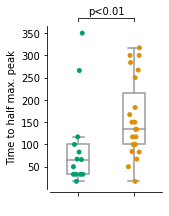

In [18]:
fig, ax = plt.subplots(1,1,figsize=(2,3))

sns.stripplot(ax=ax,
              data=df_half_peak, 
              orient="v", 
              x='kernel',
              y='t_half_max_to_peak',
              palette=[color_dict['green'], color_dict['orange']],
              s=5, 
              jitter=0.1, 
             )
sns.boxplot(ax=ax,
              data=df_half_peak, 
              orient="v", 
              x='kernel',
              y='t_half_max_to_peak',
              palette=['white', 'white'], 
            width=.4,
            flierprops={"marker": ""},
             )
ax.set_xticklabels([' ', ' '])
ax.set_ylabel('Time to half max. peak')
ax.set_xlabel('')

# Annotations
annotator = Annotator(ax=ax, 
                      pairs=[('run', 'eye')], 
                      data=df_half_peak, 
                      y='t_half_max_to_peak',
                      x='kernel',
                      order=None, 
                      orient='v',
                      short_test_name=False)
annotator.set_custom_annotations(formatted_pval)
annotator.configure(loc='outside', fontsize=10, line_width=1)
annotator.annotate()   

sns.despine(offset=3)